## ATSC 528 Homework 1: Function Fitting  
Author: Brian T. Horan  
Created: 09/12/2022  
Assignment: ATSC 528 HW 1  
Purpose: To take 500 mb upper-air RAOB's and plot them on the polar stereographic projection using function fitting. The code reads in the data through pandas. The grid is created using numpy meshgrid, and plotted to verify correctness. Next, the Lats/Lons from the observations are converted to x and y coordinates, in CM, to analyze for radii of influence. The Gilchrest and Cressman (1954) method is implemented with a series of matrices to find analysis values at each grid point. These analysis values for each radii of influence are plotted on a polar stereographic projection over the grid. The number of obs available in the roi are outputted to a text file and contoured on a polar stereographic projection as well. 

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd

In [3]:
### Read in observations ###
ds = pd.read_csv('./RAOBs_201903131200.txt',header = 6, names = ['Station', 'Lat', 'Lon', 'Height', 'Wind_dir', 'Wind_spd'])
lons = ds['Lon']
lats = ds['Lat']
hgts_500 = ds['Height']

In [4]:
### Set up analysis map with a 22x28 rectangular grid of points ###
#Analysis Map is a polar stereographic projection with 22 x points and 28 y points
x_o = 18.90
y_o = -6.3
del_x = 1.27
del_y = 1.27
x_n = 22
y_n = 28


x_grid = np.arange(start = x_o, stop = (x_o+x_n*del_x) - 1, step=del_x)
y_grid = np.arange(start = y_o, stop = (y_o+y_n*del_y) - 1, step=del_y)
xs, ys = np.meshgrid(x_grid, y_grid)

In [5]:
#convert x/y grid to lats and lons to plot grid

rho = 6371 * 1e5
psi_0 = 60 * (np.pi/180)
map_proj = 1/(15e6)
lambda_not = -115

LATS_grid = (180/np.pi) * ((np.pi/2) - (2*np.arctan((np.sqrt((xs/map_proj)**2 + (ys/map_proj)**2))/(rho*(1+np.sin(psi_0)))))) 
LONS_grid = np.arctan(ys/xs) * (180/np.pi) + lambda_not

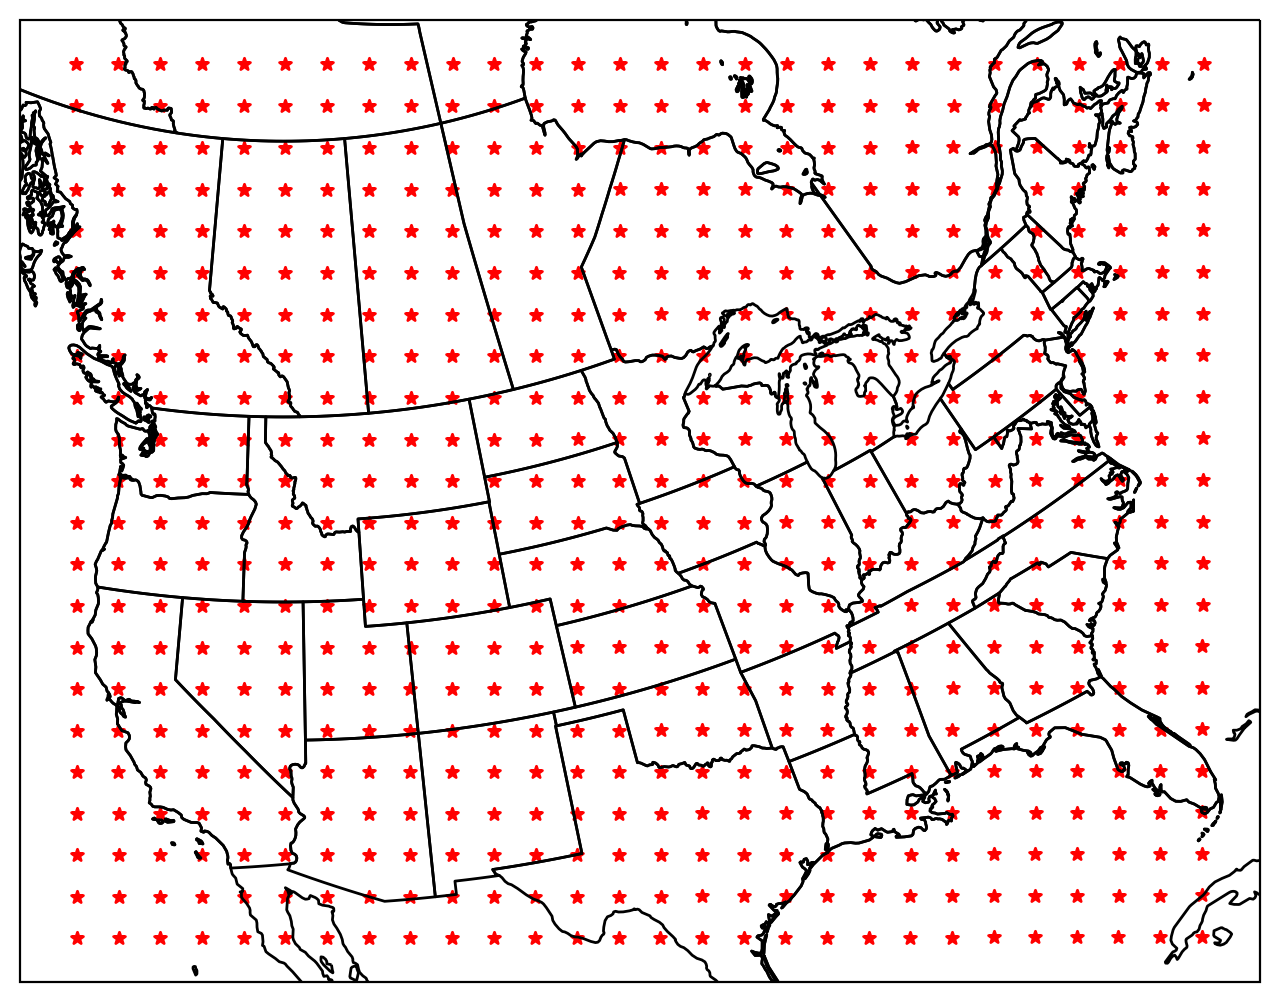

In [6]:
# plot grid to verify
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(LONS_grid.ravel(), LATS_grid.ravel(), c = 'r', marker = '*', s = 20, transform = ccrs.PlateCarree())

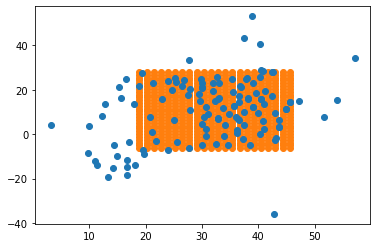

In [7]:
### convert obs lat/long to x,y (may want to plot on your analysis grid to verify)### 
sigma = (1+np.sin(psi_0))/(1+np.sin((lats*(np.pi/180))))
r = rho * sigma * np.cos(lats*((np.pi/180))) * map_proj
y_observed = r*np.sin((lons*(np.pi/180))-lambda_not * (np.pi/180))
x_observed = r*np.cos(((lons*(np.pi/180)) - (lambda_not*(np.pi/180))))

#This plot shows that the obs and grids line up
plt.scatter(x_observed, y_observed, zorder = 10)
plt.scatter(xs.ravel(), ys.ravel(), zorder = 1)

In [8]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

#Create the matrices/vectors to find the analysis value at a given grid point (x,y) with a given roi
rois = np.array([10, 20])


analysis_arr = np.empty((y_n, x_n, len(rois)))
n_obs_arr = np.empty((y_n, x_n, len(rois)))

for n_roi in range(len(rois)):
    roi = rois[n_roi]
    for i in range(len(xs[0])):
        for j in range(len(xs)):
            rel_x = xs[j, i] - x_observed
            rel_y = ys[j, i] - y_observed
            rel_rad = (rel_x ** 2 + rel_y**2)**0.5
            ind_rois = np.where(rel_rad<roi)[0]
            n_obs_arr[j, i, n_roi] = len(ind_rois)
        
            x_k = rel_x[ind_rois].values
            y_k = rel_y[ind_rois].values
            fo = hgts_500[ind_rois].values
            matrix_r = np.zeros((6,6))
            matrix_o = np.zeros(6)
        
        
            for k in range(len(x_k)):
                tmp1 = np.matrix([[1, x_k[k], y_k[k], x_k[k]**2, y_k[k]**2, x_k[k]*y_k[k]]])
                tmp2 = tmp1.T * tmp1
                matrix_r += tmp2
                matrix_o += np.array([fo[k], x_k[k]*fo[k], y_k[k]*fo[k], x_k[k]**2 * fo[k], y_k[k]**2 * fo[k], x_k[k] * y_k[k] * fo[k]])
        
            matrix_r = matrix_r/n_obs_arr[j, i, n_roi]
            matrix_o = matrix_o/n_obs_arr[j, i, n_roi]
            C = np.linalg.inv(matrix_r) * np.matrix(matrix_o).T
            analysis_arr[j, i, n_roi] = C[0,0]
            #do the matrix and save to a file
                #with open ('Horan_hw1_analysis_points_roi'+str(roi)+'.csv', header = ['x_point', 'y_point', 'num_of_analysis_pts', 'analysis_val'], index = False) as f:
                    #f.write(

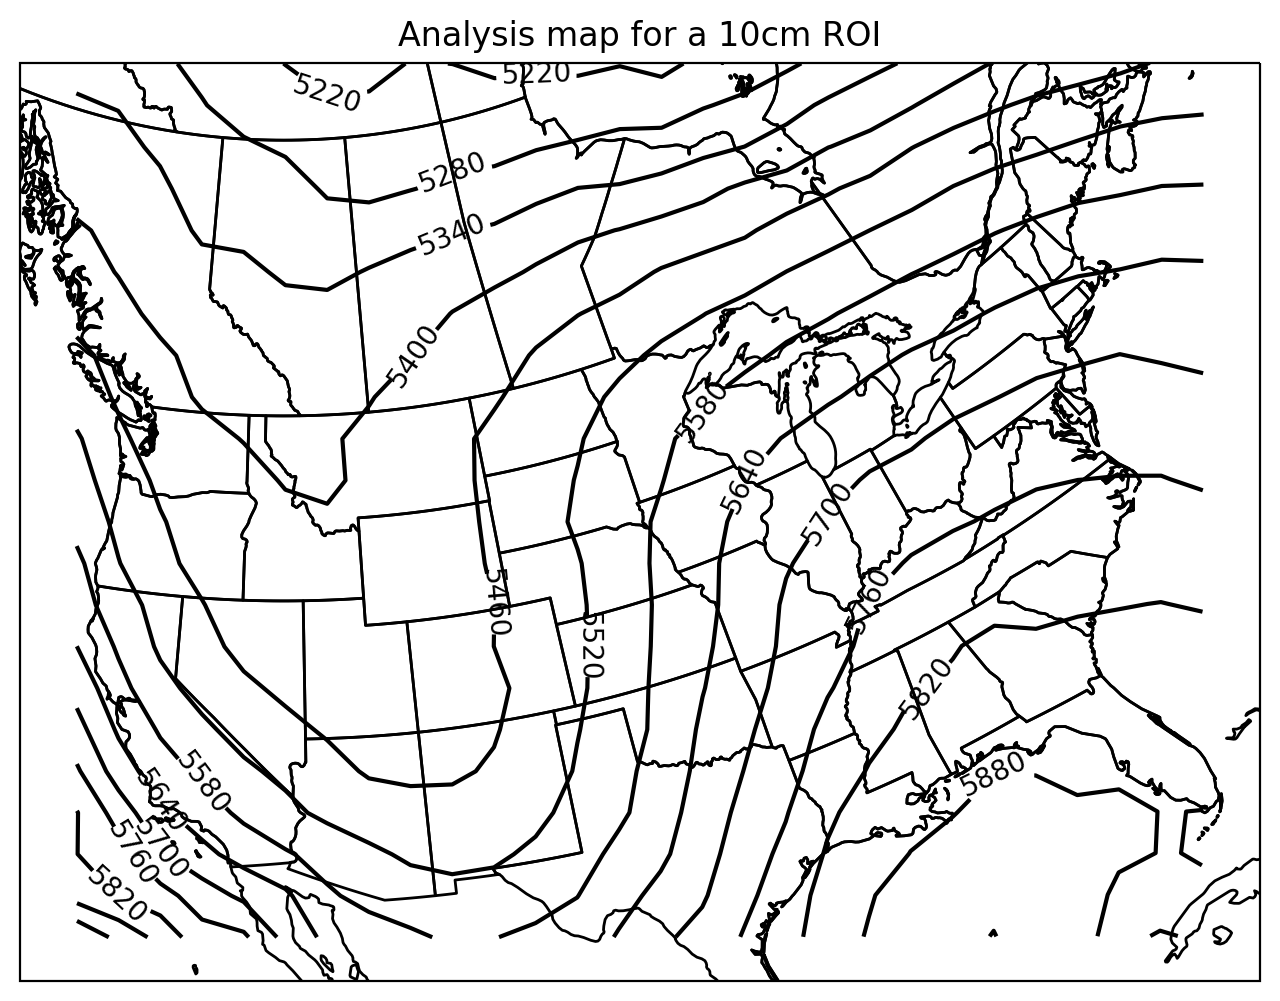

In [17]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LONS_grid,LATS_grid,analysis_arr[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis map for a 10cm ROI')
plt.show()


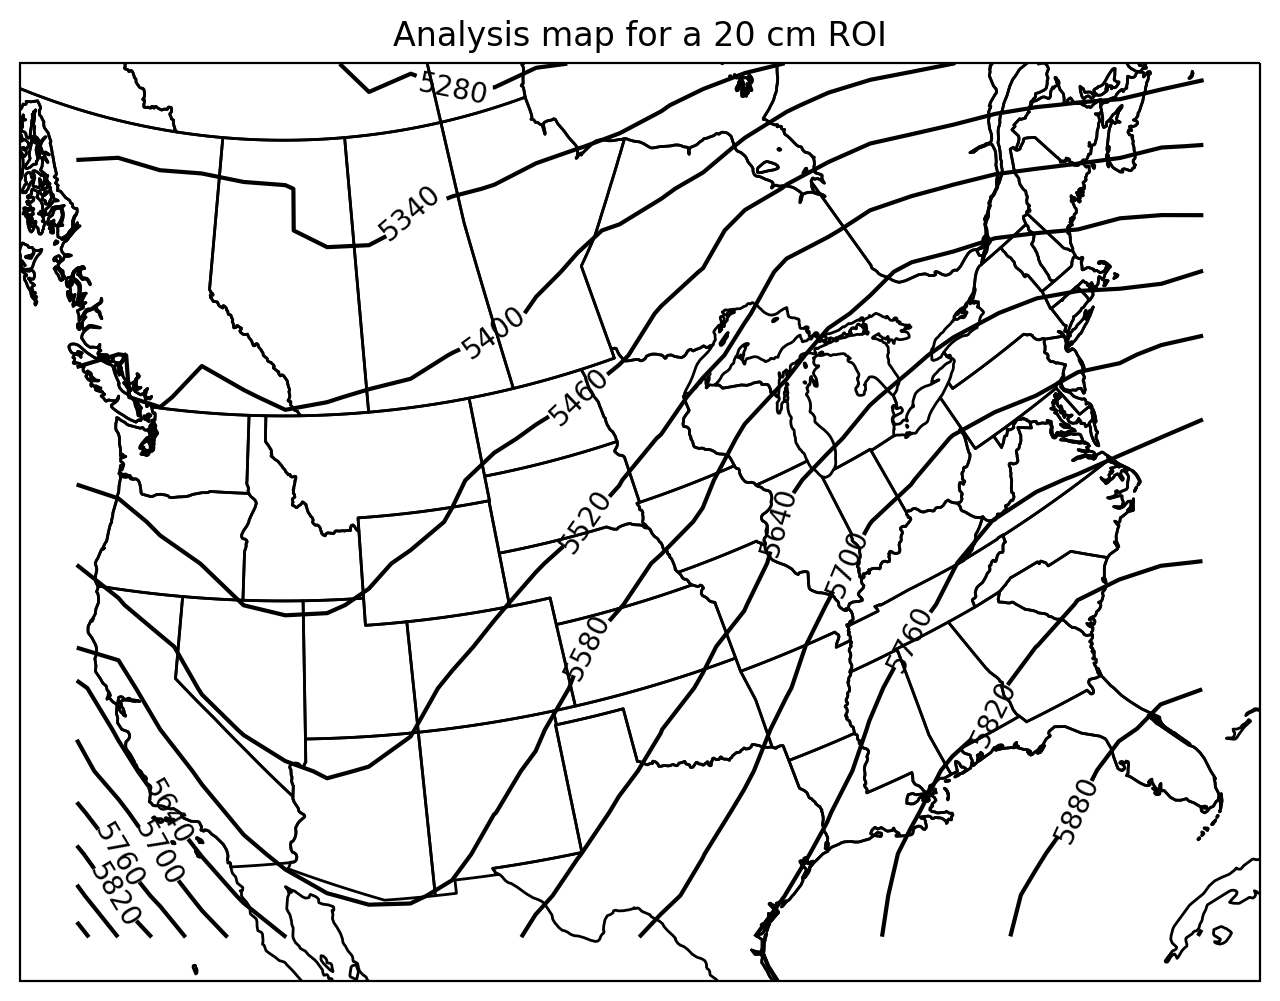

In [16]:
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LONS_grid,LATS_grid,analysis_arr[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis map for a 20 cm ROI')
plt.show()


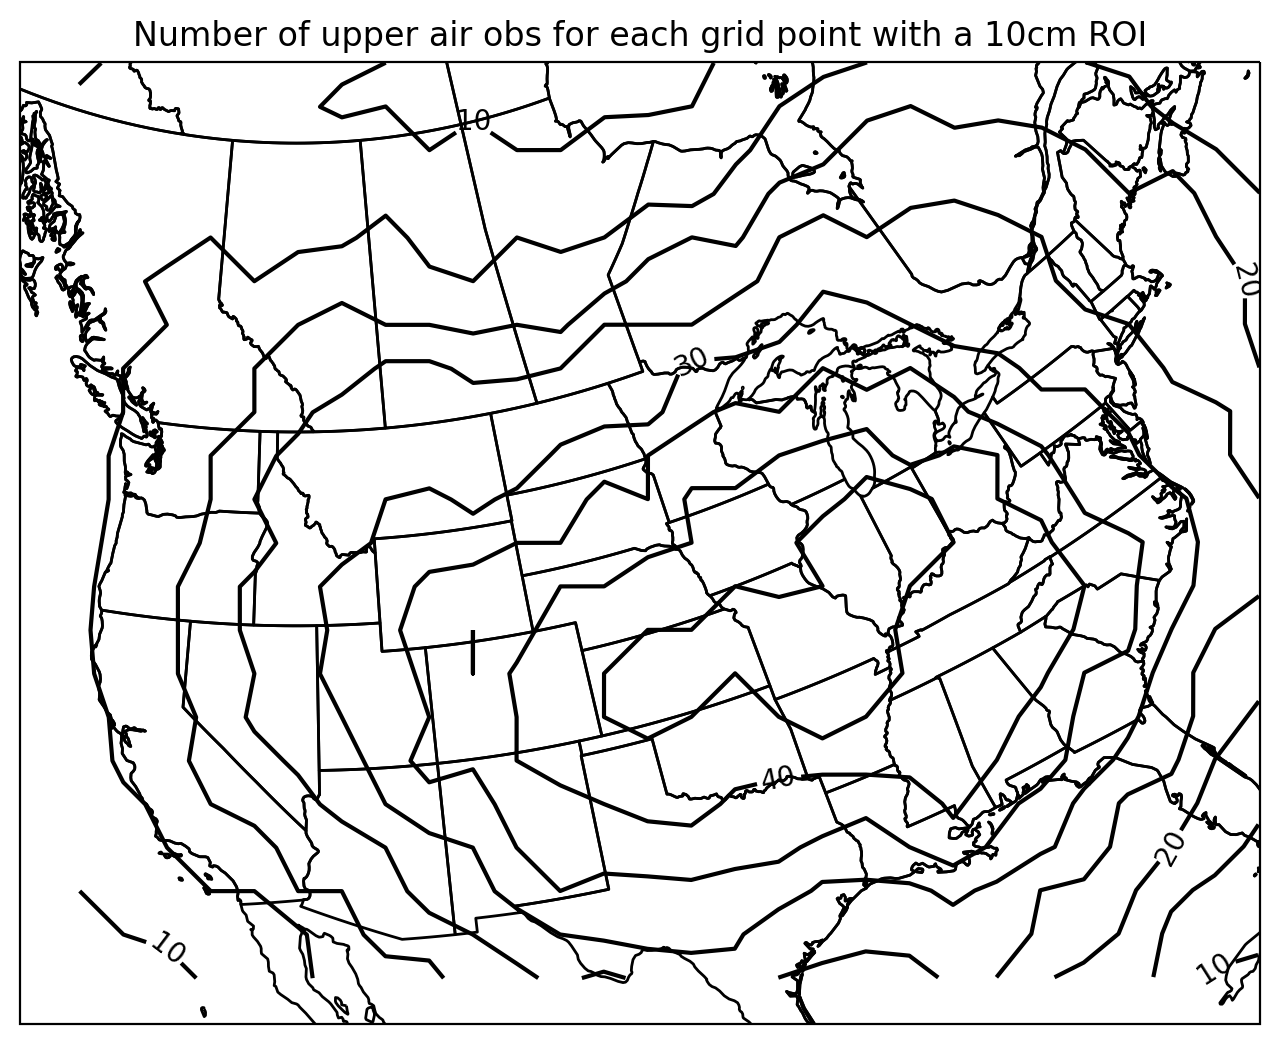

In [14]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LONS_grid,LATS_grid,n_obs_arr[:,:,0],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('Number of upper air obs for each grid point with a 10cm ROI')
plt.show()

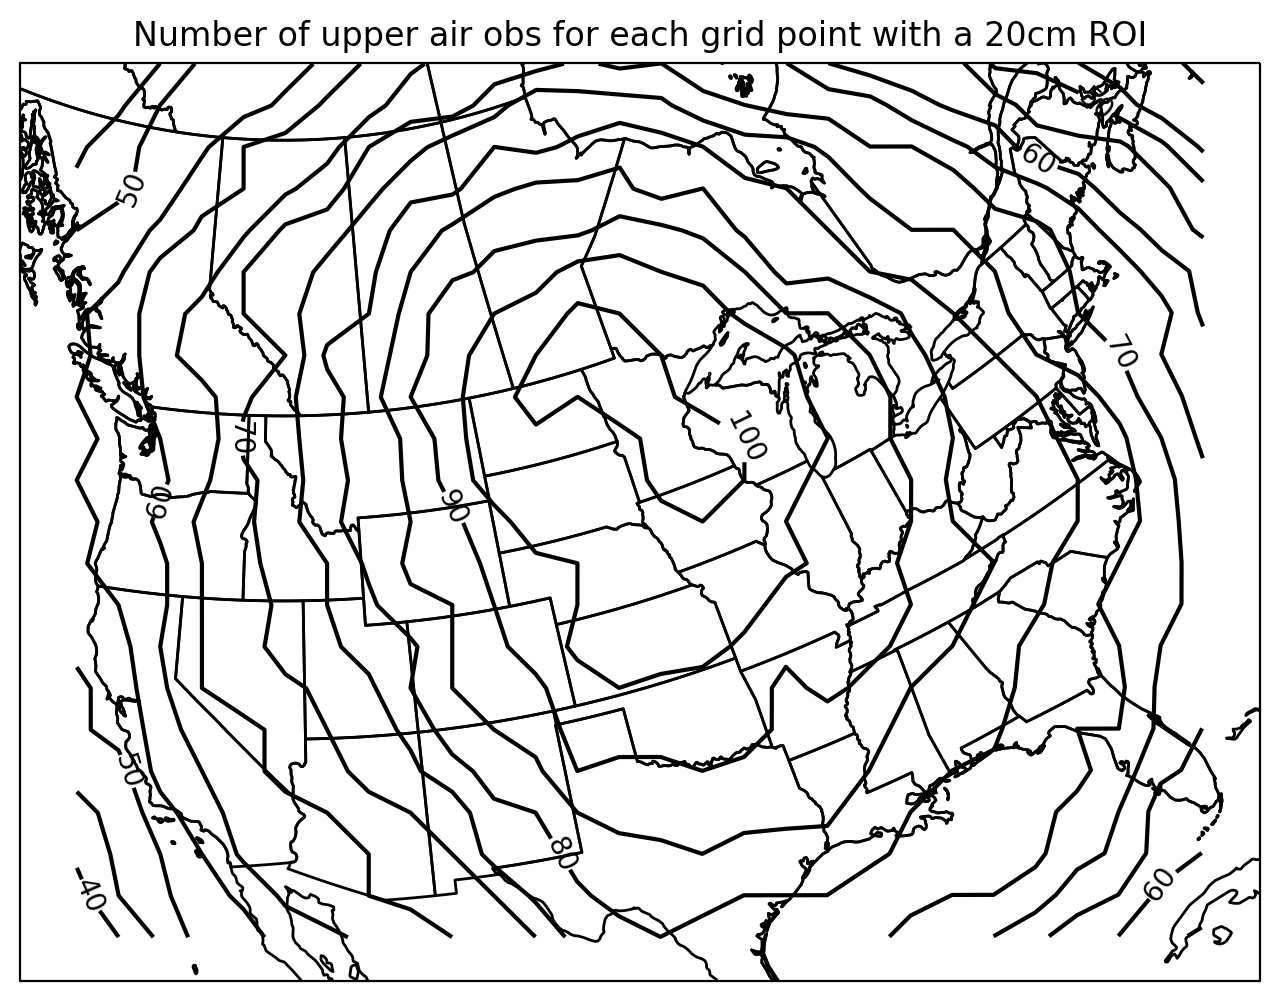

In [15]:
### Plot number of observations available to polynomial fitting scheme for each grid point ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot number of observations (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(LONS_grid,LATS_grid,n_obs_arr[:,:,1],colors='k',levels=np.arange(0,200,5),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,200,10))
plt.title('Number of upper air obs for each grid point with a 20cm ROI')
plt.show()

In [23]:
### Store the analyses in text files ###
with open('HW1_roi_10_Horan.txt', 'a+') as f:
    f.write('grid_point, number_obs_available, analysis_value\n')
    for i in range(len(xs)):
        for j in range(len(xs[0])):
            grid_point = str([i,j])
            n_obs_avail = str(n_obs_arr[i,j,0])
            analysis_val = str(analysis_arr[i,j,0])
            out_str = grid_point + ',' + n_obs_avail + ',' + analysis_val + '\n'
            f.write(out_str)


In [24]:
### Store the number of observations available for each grid point in text files ###
with open('HW1_roi_20_Horan.txt', 'a+') as f:
    f.write('grid_point, number_obs_available, analysis_value\n')
    for i in range(len(xs)):
        for j in range(len(xs[0])):
            grid_point = str([i,j])
            n_obs_avail = str(n_obs_arr[i,j,1])
            analysis_val = str(analysis_arr[i,j,1])
            out_str = grid_point + ',' + n_obs_avail + ',' + analysis_val + '\n'
            f.write(out_str)



In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
        There is a large trough over the western US in both analyses but it is deeper and more defined on the 10cm roi analysis

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
        The 20cm analysis map is smoother than the 10cm roi map. The 20cm roi map has too large of an influence and therefore the large volume of data somewhat smooths out the 
        features of interest in the upper air observations

3 - Run your program using a radius of influence of 6 cm (do not need to show).  
    Describe the results - do they look realistic?  If there are problems, what
    do you think might be causing them?
        The problem is that there is a singular matrix for at least one of the ROI's (see code below) and so it cannot be inverted becasue there are no values in the matrix
        

4 - Suppose you ran this program with a small enough radius of influence that only one
    observation was available for determining a polynomial fit at a grid point.  Should
    you be able to perform the matrix inversion?  Why or why not?
        No, because it is a singular matrix and the determinant matrix would be zero.

'''

In [25]:
### Perform 500mb geopotential height analyses using a second order 2-d polynomial with two ###
### radii of influence (10cm & 20cm) ###

#Create the matrices/vectors to find the analysis value at a given grid point (x,y) with a given roi
rois = np.array([6, 10, 20])


analysis_arr = np.empty((y_n, x_n, len(rois)))
n_obs_arr = np.empty((y_n, x_n, len(rois)))

for n_roi in range(len(rois)):
    roi = rois[n_roi]
    for i in range(len(xs[0])):
        for j in range(len(xs)):
            rel_x = xs[j, i] - x_observed
            rel_y = ys[j, i] - y_observed
            rel_rad = (rel_x ** 2 + rel_y**2)**0.5
            ind_rois = np.where(rel_rad<roi)[0]
            n_obs_arr[j, i, n_roi] = len(ind_rois)
        
            x_k = rel_x[ind_rois].values
            y_k = rel_y[ind_rois].values
            fo = hgts_500[ind_rois].values
            matrix_r = np.zeros((6,6))
            matrix_o = np.zeros(6)
        
        
            for k in range(len(x_k)):
                tmp1 = np.matrix([[1, x_k[k], y_k[k], x_k[k]**2, y_k[k]**2, x_k[k]*y_k[k]]])
                tmp2 = tmp1.T * tmp1
                matrix_r += tmp2
                matrix_o += np.array([fo[k], x_k[k]*fo[k], y_k[k]*fo[k], x_k[k]**2 * fo[k], y_k[k]**2 * fo[k], x_k[k] * y_k[k] * fo[k]])
        
            matrix_r = matrix_r/n_obs_arr[j, i, n_roi]
            matrix_o = matrix_o/n_obs_arr[j, i, n_roi]
            C = np.linalg.inv(matrix_r) * np.matrix(matrix_o).T
            analysis_arr[j, i, n_roi] = C[0,0]

LinAlgError: Singular matrix

In [ ]:
signed. For example, tf.matmul has both CPU and GPU kernels and on a system with devices CPU:0 and GPU:0, the GPU:0 device is selected to run tf.matmul unless you explici